อ่านไฟล์ '../data/robot_log_with_yaw.csv' สำเร็จ มีข้อมูลทั้งหมด 1638 แถว


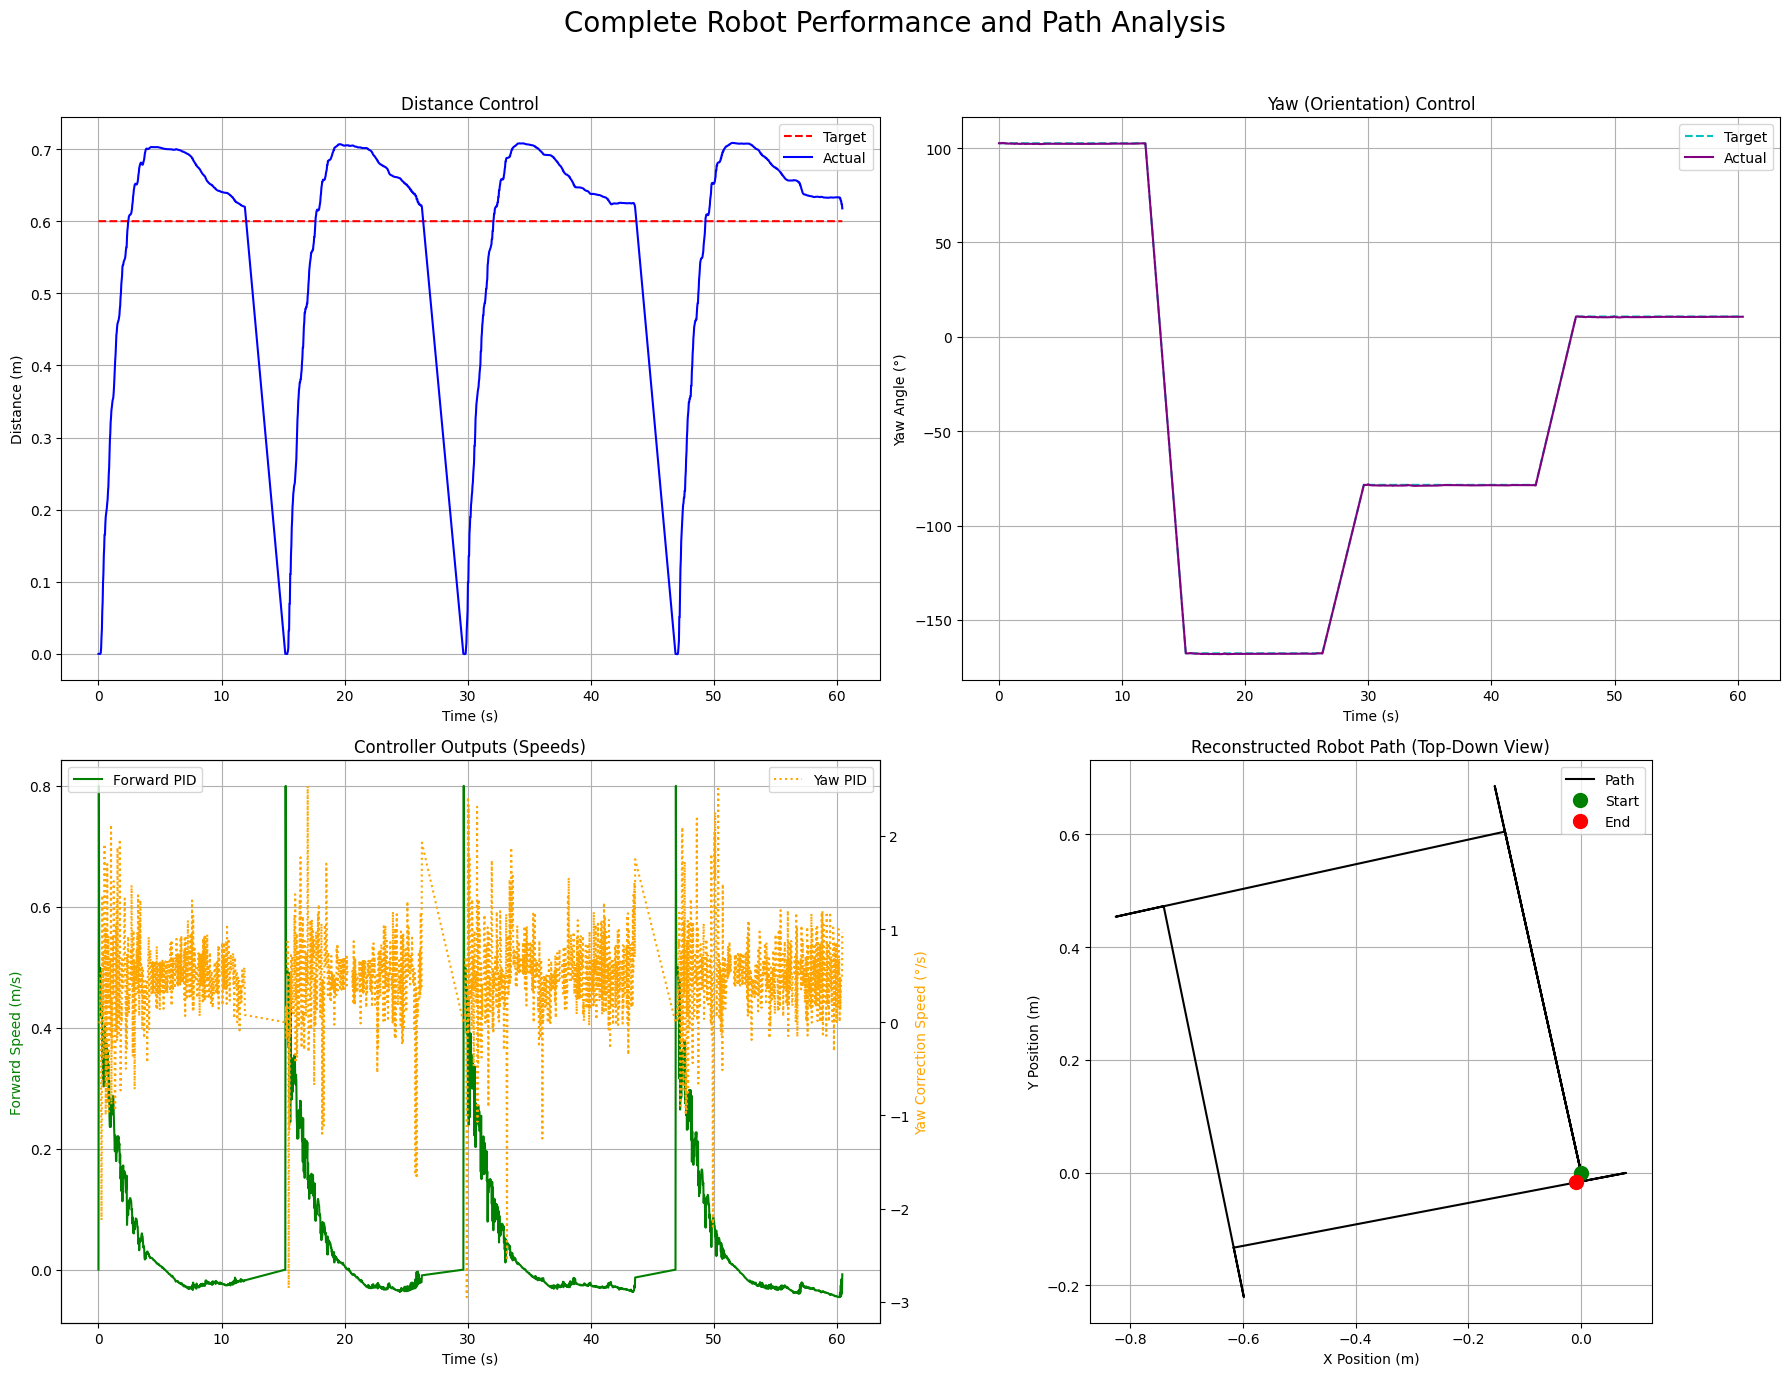

In [2]:
# Magic command เพื่อให้ Jupyter แสดงกราฟใน cell output
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_with_path(log_filename="../data/robot_log_with_yaw.csv"):
    """
    อ่านข้อมูลและพล็อตกราฟวิเคราะห์ประสิทธิภาพทั้งหมด
    พร้อมทั้งคำนวณและพล็อตเส้นทางการเคลื่อนที่ (X-Y Path) ของหุ่นยนต์
    """
    try:
        df = pd.read_csv(log_filename)
        print(f"อ่านไฟล์ '{log_filename}' สำเร็จ มีข้อมูลทั้งหมด {len(df)} แถว")
    except FileNotFoundError:
        print(f"หาไฟล์ '{log_filename}' ไม่พบ! กรุณาตรวจสอบว่าไฟล์อยู่ในตำแหน่งที่ถูกต้อง")
        return

    # =================================================================
    # == ส่วนคำนวณย้อนกลับเพื่อสร้างพิกัด X, Y (Path Reconstruction) ==
    # =================================================================
    x_coords = [0]
    y_coords = [0]
    current_x, current_y = 0.0, 0.0

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]

        # คำนวณระยะทางที่เปลี่ยนไปจาก step ที่แล้ว
        if row['side'] == prev_row['side']:
            delta_dist = row['current_distance'] - prev_row['current_distance']
        else:
            # เมื่อขึ้นด้านใหม่, ค่า current_distance จะเริ่มนับใหม่
            # ดังนั้น delta_dist คือค่า current_distance ของ step แรกในด้านใหม่
            delta_dist = row['current_distance']

        # หาทิศทาง (Yaw) เป็นเรเดียน
        yaw_rad = math.radians(row['target_yaw'])

        # คำนวณการเปลี่ยนแปลงของ X และ Y
        delta_x = delta_dist * math.cos(yaw_rad)
        delta_y = delta_dist * math.sin(yaw_rad)

        # อัปเดตตำแหน่งปัจจุบัน
        current_x += delta_x
        current_y += delta_y

        x_coords.append(current_x)
        y_coords.append(current_y)

    # เพิ่มคอลัมน์ x, y ที่คำนวณได้เข้าไปใน DataFrame
    df['x_pos'] = x_coords
    df['y_pos'] = y_coords
    # =================================================================

    # สร้าง subplot 4 กราฟ (รูปแบบ 2x2)
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Complete Robot Performance and Path Analysis', fontsize=20)

    # --- 1. กราฟระยะทาง (บนซ้าย) ---
    axs[0, 0].set_title('Distance Control')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Distance (m)')
    axs[0, 0].plot(df['timestamp'], df['target_distance'], label='Target', ls='--', c='r')
    axs[0, 0].plot(df['timestamp'], df['current_distance'], label='Actual', c='b')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # --- 2. กราฟทิศทาง (บนขวา) ---
    axs[0, 1].set_title('Yaw (Orientation) Control')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Yaw Angle (°)')
    axs[0, 1].plot(df['timestamp'], df['target_yaw'], label='Target', ls='--', c='c')
    axs[0, 1].plot(df['timestamp'], df['current_yaw'], label='Actual', c='purple')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # --- 3. กราฟความเร็วจาก PID (ล่างซ้าย) ---
    axs[1, 0].set_title('Controller Outputs (Speeds)')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Forward Speed (m/s)', color='g')
    axs[1, 0].plot(df['timestamp'], df['pid_speed_output'], label='Forward PID', c='g')
    axs[1, 0].legend(loc='upper left')
    ax_twin = axs[1, 0].twinx()
    ax_twin.set_ylabel('Yaw Correction Speed (°/s)', color='orange')
    ax_twin.plot(df['timestamp'], df['yaw_correction_speed'], label='Yaw PID', ls=':', c='orange')
    ax_twin.legend(loc='upper right')
    axs[1, 0].grid(True)

    # --- 4. กราฟเส้นทางการเดิน (ล่างขวา) ---
    axs[1, 1].set_title('Reconstructed Robot Path (Top-Down View)')
    axs[1, 1].set_xlabel('X Position (m)')
    axs[1, 1].set_ylabel('Y Position (m)')
    axs[1, 1].plot(df['x_pos'], df['y_pos'], label='Path', c='black')
    axs[1, 1].plot(df['x_pos'][0], df['y_pos'][0], 'go', markersize=10, label='Start') # จุดเริ่มต้น
    axs[1, 1].plot(df['x_pos'].iloc[-1], df['y_pos'].iloc[-1], 'ro', markersize=10, label='End') # จุดสิ้นสุด
    axs[1, 1].set_aspect('equal', adjustable='box') # **สำคัญมาก: ทำให้สเกลแกน X และ Y เท่ากัน**
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- เรียกใช้ฟังก์ชัน ---
plot_with_path()